In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

In [2]:
pd.options.display.max_rows=100
pd.options.display.max_columns=None

In [3]:
path = '/kaggle/input/playground-series-s4e3/'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [4]:
train_data = pd.read_csv(path + 'train.csv')
original_data = pd.read_csv('/kaggle/input/faulty-steel-plates/' + 'faults.csv')
TARGET_FEATURES = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']
test_data = pd.read_csv(path + 'test.csv')

In [5]:
print(train_data.shape)
print(original_data.shape)
print(test_data.shape)


(19219, 35)
(1941, 34)
(12814, 28)


In [6]:
train_data.drop(['id'],axis = 1,inplace = True)
test_data.drop(['id'],inplace = True,axis = 1)
train_data = pd.concat([train_data,original_data],axis = 0)
train_data.reset_index(drop=True, inplace=True)

# Drop multi label data points

In [7]:
train_data = train_data[train_data[TARGET_FEATURES].sum(axis=1) <= 1]
train_data['Outside_Global_Index'] = np.where(train_data['Outside_Global_Index']==0.7, 0.5, train_data['Outside_Global_Index'])
targets_bin = train_data[TARGET_FEATURES]
y_xgb = targets_bin

In [8]:
targets_bin

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
21155,0,0,0,0,0,0,1
21156,0,0,0,0,0,0,1
21157,0,0,0,0,0,0,1
21158,0,0,0,0,0,0,1


# Create a label encoded target column

In [9]:
# 7개의 결함 중에서 어느것에 속하는 지 'Target'으로 표시하고 만약 어느것에도 해당하지 아니하면 
# 0이 부여된다.
train_data['Target'] = np.argmax(train_data[TARGET_FEATURES].values, axis=1) + 1
train_data.loc[train_data[TARGET_FEATURES].sum(axis=1) == 0, 'Target'] = 0
train_data.drop(TARGET_FEATURES, inplace=True,axis =1)

In [10]:
train_data


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,4
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,7
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,3
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,3
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21155,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.3662,0.3906,0.5714,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,7
21156,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.2118,0.4554,0.5484,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,7
21157,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.2132,0.3287,0.5172,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,7
21158,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.2015,0.5904,0.9394,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,7


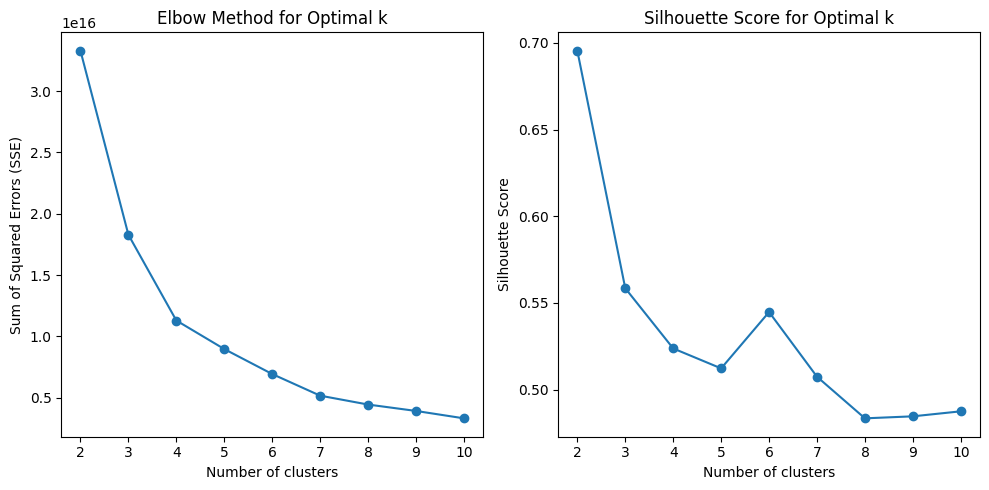

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 클러스터링에 사용할 특성 선택
features = ['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Steel_Plate_Thickness']

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
sse = []
silhouette_scores = []
k_range = range(2, 11)


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train[features])
    sse.append(kmeans.inertia_)  # SSE
    silhouette_avg = silhouette_score(train[features], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# SSE (Elbow Method) 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')

# 실루엣 스코어 그래프
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

## Feature Importance


# Feature Engineering

In [11]:
# new features 
def feature_engineering(data):
    data['Ratio_Length_Thickness'] = data['Length_of_Conveyer'] / data['Steel_Plate_Thickness']
    data['Average_Luminosity'] = data['Sum_of_Luminosity'] / data['Pixels_Areas']
    data['X_Range*Pixels_Areas'] = (data['X_Maximum'] - data['X_Minimum']) * data['Pixels_Areas']
    return data
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [12]:

# 클러스터링에 사용할 특성 선택
features = ['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Steel_Plate_Thickness']
# 클러스터링 모델 생성 및 학습
kmeans = KMeans(n_clusters=4)

kmeans.fit(train_data[features])
# train 데이터에 클러스터링 결과 추가
train_data['Cluster'] = kmeans.labels_
# test 데이터에 클러스터링 결과 추가
test_data['Cluster'] = kmeans.predict(test_data[features])


NameError: name 'KMeans' is not defined

In [13]:
# log scaling 
for col in ['X_Perimeter','Steel_Plate_Thickness','Pixels_Areas']:
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])

In [14]:
features_to_drop = ['Y_Minimum', 'Steel_Plate_Thickness', 'Sum_of_Luminosity', 'Edges_X_Index', 'SigmoidOfAreas', 'Luminosity_Index']

In [15]:
train_data = train_data.drop(features_to_drop,axis = 1)
test_data = test_data.drop(features_to_drop,axis = 1)

In [16]:
X = train_data.drop(['Target'], axis=1)  
y = train_data['Target']  

In [17]:
y

0        4
1        7
2        3
3        3
4        7
        ..
21155    7
21156    7
21157    7
21158    7
21159    7
Name: Target, Length: 21139, dtype: int64

## XGB Training

In [17]:
RETRAIN_XGB_MODEL = True
def objective(trial):
    # Define hyperparameters to tune
    param = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'multi_strategy': trial.suggest_categorical('multi_strategy', ["one_output_per_tree"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'gamma' : trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        
    }
    param['n_estimators'] = 3000
    param['early_stopping_rounds'] = 50
    param['booster'] = 'gbtree'
    param["verbosity"] = 0
    param['tree_method'] = "hist"
    
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        y_xgb_train_fold, y_xgb_valid_fold = y_xgb.iloc[train_idx], y_xgb.iloc[valid_idx]
                
        # Create and fit the model
        model = XGBClassifier(**param)
        model.fit(X_train_fold, y_xgb_train_fold, eval_set=[(X_valid_fold, y_xgb_valid_fold)],verbose=False)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob, multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)


if RETRAIN_XGB_MODEL:
    study = optuna.create_study(direction='maximize',study_name = "xgb_model_training")
    study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

[I 2024-06-02 06:46:41,320] A new study created in memory with name: xgb_model_training
[I 2024-06-02 06:47:41,390] Trial 0 finished with value: 0.8952966754186369 and parameters: {'grow_policy': 'depthwise', 'multi_strategy': 'one_output_per_tree', 'learning_rate': 0.055871195295998446, 'gamma': 0.0016695770085156914, 'subsample': 0.7297368672966174, 'colsample_bytree': 0.6432218573013058, 'max_depth': 13, 'min_child_weight': 7, 'lambda': 4.632028115551005, 'alpha': 0.05411880472061667}. Best is trial 0 with value: 0.8952966754186369.
[I 2024-06-02 06:55:49,508] Trial 1 finished with value: 0.8973520544361264 and parameters: {'grow_policy': 'lossguide', 'multi_strategy': 'one_output_per_tree', 'learning_rate': 0.006849870044136595, 'gamma': 0.0004184827747364678, 'subsample': 0.6409465701243184, 'colsample_bytree': 0.829147024815629, 'max_depth': 9, 'min_child_weight': 2, 'lambda': 0.0485525962956158, 'alpha': 0.01224423059238267}. Best is trial 1 with value: 0.8973520544361264.
[I 20

Best trial average AUC: 0.8983
{'grow_policy': 'depthwise', 'multi_strategy': 'one_output_per_tree', 'learning_rate': 0.00570169533937645, 'gamma': 1.7822267499229357e-05, 'subsample': 0.3454465003055752, 'colsample_bytree': 0.3153665259957889, 'max_depth': 9, 'min_child_weight': 1, 'lambda': 0.028323821907999397, 'alpha': 0.006004754703873118}
grow_policy: depthwise
multi_strategy: one_output_per_tree
learning_rate: 0.00570169533937645
gamma: 1.7822267499229357e-05
subsample: 0.3454465003055752
colsample_bytree: 0.3153665259957889
max_depth: 9
min_child_weight: 1
lambda: 0.028323821907999397
alpha: 0.006004754703873118


## LGBM Training

In [18]:
RETRAIN_LGBM_MODEL = True
def objective(trial):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
    'objective': 'multiclass',  # Equivalent to multi:softmax but needs num_class as well
    'num_class': 8,  # Specify the number of classes if your task is multi-class classification
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
    'n_estimators': 3000,
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
    'device_type': 'cpu',    'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),"verbosity": -1,"early_stopping_rounds": 50,
    }
    auc_scores = []
    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        model = LGBMClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], verbose=False)
        y_prob = model.predict_proba(X_valid_fold)
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)
    return np.mean(auc_scores)
# Run Optuna optimization
if RETRAIN_LGBM_MODEL:
    lgbm_study = optuna.create_study(direction='maximize',study_name = "lgbm_model_training")
    lgbm_study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

## Catboost Training

In [19]:
RETRAIN_CATBOOST_MODEL = True

def objective(trial):
    # Define parameters to be optimized for the CatBoostClassifier
    param = {
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        'n_estimators': 2000,
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.001, 10.0, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "bootstrap_type": "Bernoulli",
        "early_stopping_rounds": 100,
        "task_type": 'CPU',
        "verbose": False
    }

    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Create and fit the model
        model = CatBoostClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)

if RETRAIN_CATBOOST_MODEL:
    # Run Optuna optimization
    catboost_study = optuna.create_study(direction='maximize', study_name="catboost_model_training")
    catboost_study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary

    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

## HGBC Training

In [1]:
RETRAIN_HGBC_MODEL = True

def objective(trial):
    # Define hyperparameters to tune
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_iter': trial.suggest_int('max_iter', 100, 2500),  # Equivalent to n_estimators
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 10.0, log=True),  # Equivalent to reg_lambda
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 300),
        'max_bins': trial.suggest_int('max_bins', 25, 255),
    }
    
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Create and fit the model
        model = HistGradientBoostingClassifier(**param)
        model.fit(X_train_fold, y_train_fold)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)


if RETRAIN_HGBC_MODEL:
    # Example usage with Optuna
    hgbc_study = optuna.create_study(direction='maximize', study_name="HistGradientBoostingClassifier_model_training")
    hgbc_study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary

    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

NameError: name 'optuna' is not defined

In [23]:
lgbm_params = {
    "objective": "multiclass",
    'num_class': 8,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "early_stopping_rounds": 50,
    'n_estimators': 3000,
    'learning_rate': 0.00711725041768046,
    'lambda_l1': 0.00440985033109004,
    'lambda_l2': 1.0606279361419868e-08,
    'max_depth': 8,
    'colsample_bytree': 0.33443191322905963,
    'subsample': 0.6551114943335209,
    'min_child_weight': 1,
    'num_leaves': 1019,
    'min_child_samples': 94,
}

cat_params = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "bootstrap_type": "Bernoulli",
    "early_stopping_rounds": 100,
    "verbose": False,
    'n_estimators': 2000,
    'learning_rate': 0.018384945397206656,
    'l2_leaf_reg': 0.8746200477430335,
    'depth': 6,
    'colsample_bylevel': 0.1250483657354198,
    'subsample': 0.8794673581253512
}

xgb_params = {
    'grow_policy': 'depthwise',
    'multi_strategy': 'multi_output_tree',
    'n_estimators': 3000,
    'early_stopping_rounds': 50,
    'learning_rate': 0.011991933688453596,
    'gamma': 0.037522403671044376,
    'subsample': 0.8810951837647127,
    'colsample_bytree': 0.36803100807865063,
    'max_depth': 7,
    'min_child_weight': 2,
    'lambda': 0.38010636016035176,
    'alpha': 0.047233571811149226,
}

hgbc_params = {
    'learning_rate': 0.038914759891422,
    'max_iter': 1381,
    'max_depth': 4,
    'l2_regularization': 9.698385966882728e-07,
    'min_samples_leaf': 281,
    'max_bins': 100
}

In [24]:
def compute_oof(X, y, model, model_name, cv):
    
    cv_oof = pd.DataFrame(np.zeros((len(y), len(TARGET_FEATURES))), columns=TARGET_FEATURES)
    prob_predictions_test = []
    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        y_xgb_train_fold, y_xgb_valid_fold = y_xgb.iloc[train_idx], y_xgb.iloc[valid_idx]

        prob_predictions = []
        if model_name == 'XGB':
            model.fit(X_train_fold, y_xgb_train_fold, eval_set=[(X_valid_fold, y_xgb_valid_fold)],verbose=False)
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)
            prob_predictions_test.append(model.predict_proba(test_data))
        elif model_name == 'LGBM':
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
        elif model_name == 'CAT':
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
        else:
            model.fit(X_train_fold, y_train_fold)
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
    preds = np.mean(prob_predictions_test, axis=0)
    return cv_oof, preds

In [25]:
cat_oof, cat_preds = compute_oof(X, y, CatBoostClassifier(**cat_params), 'CAT', cv)

In [26]:
xgb_oof, xgb_preds = compute_oof(X, y, XGBClassifier(**xgb_params), 'XGB', cv)
lgbm_oof, lgbm_preds = compute_oof(X, y, LGBMClassifier(**lgbm_params), 'LGBM', cv)

In [27]:
hgbc_oof, hgbc_preds = compute_oof(X, y, HistGradientBoostingClassifier(**hgbc_params), 'HGBC', cv)

In [28]:
xgb_preds

array([[4.3795484e-01, 2.0528513e-03, 2.1842187e-03, ..., 2.1456350e-02,
        1.2744986e-01, 4.3167478e-01],
       [2.4183258e-01, 1.7212458e-02, 6.8509891e-03, ..., 1.5524131e-01,
        1.5668714e-01, 3.4673885e-01],
       [2.0434011e-03, 3.8126275e-02, 5.7881188e-02, ..., 4.6839691e-03,
        3.3238477e-01, 5.1261157e-01],
       ...,
       [4.0986910e-04, 5.5201270e-04, 9.2287320e-01, ..., 3.9685471e-04,
        7.2293449e-04, 6.3758478e-02],
       [4.4470486e-01, 8.4057832e-03, 1.5188443e-02, ..., 7.3491484e-02,
        1.3390525e-01, 3.1436673e-01],
       [8.5273932e-04, 1.8816661e-03, 8.7644988e-01, ..., 8.5882179e-04,
        1.7672541e-03, 1.0464263e-01]], dtype=float32)

In [29]:
MinMax = 0
# 0 None
# 1 MinMax min to 0 max to 1
# 2 scale a row sum to 1
if MinMax == 1:
    xgb_oof = MinMaxScaler().fit_transform(xgb_oof)
    lgbm_oof = MinMaxScaler().fit_transform(lgbm_oof)
    cat_oof = MinMaxScaler().fit_transform(cat_oof)
    hgbc_oof = MinMaxScaler().fit_transform(hgbc_oof)
    xgb_preds = MinMaxScaler().fit_transform(xgb_preds)
    lgbm_preds = MinMaxScaler().fit_transform(lgbm_preds)
    cat_preds = MinMaxScaler().fit_transform(cat_preds)
    hgbc_preds = MinMaxScaler().fit_transform(hgbc_preds)
elif MinMax == 2:
    xgb_oof = xgb_oof.div(xgb_oof.sum(axis=1), axis=0)
    lgbm_oof = lgbm_oof.div(lgbm_oof.sum(axis=1), axis=0)
    cat_oof = cat_oof.div(cat_oof.sum(axis=1), axis=0)
    hgbc_oof = hgbc_oof.div(hgbc_oof.sum(axis=1), axis=0)
    xgb_oof = np.array(xgb_oof)
    lgbm_oof = np.array(lgbm_oof)
    cat_oof = np.array(cat_oof)
    hgbc_oof = np.array(hgbc_oof)
    xgb_preds = xgb_preds / xgb_preds.sum(axis=1, keepdims=True)
    lgbm_preds = lgbm_preds / lgbm_preds.sum(axis=1, keepdims=True)
    cat_preds = cat_preds / cat_preds.sum(axis=1, keepdims=True)
    hgbc_preds = hgbc_preds / hgbc_preds.sum(axis=1, keepdims=True)
else:
    xgb_oof = np.array(xgb_oof)
    lgbm_oof = np.array(lgbm_oof)
    cat_oof = np.array(cat_oof)
    hgbc_oof = np.array(hgbc_oof)
    xgb_preds = np.array(xgb_preds)
    lgbm_preds = np.array(lgbm_preds)
    cat_preds = np.array(cat_preds)
    hgbc_preds = np.array(hgbc_preds)

In [30]:
xgb_score = roc_auc_score(targets_bin, xgb_oof, multi_class='ovr')
lgbm_score = roc_auc_score(targets_bin, lgbm_oof, multi_class='ovr')
cat_score = roc_auc_score(targets_bin, cat_oof, multi_class='ovr')
hgbc_score = roc_auc_score(targets_bin, hgbc_oof, multi_class='ovr')

print(f"oof roc-auc score for XGB  model: {xgb_score:0.5f}")
print(f"oof roc-auc score for LGBM model: {lgbm_score:0.5f}")
print(f"oof roc-auc score for CAT  model: {cat_score:0.5f}")
print(f"oof roc-auc score for HGBC model: {hgbc_score:0.5f}")

oof roc-auc score for XGB  model: 0.89889
oof roc-auc score for LGBM model: 0.89902
oof roc-auc score for CAT  model: 0.89868
oof roc-auc score for HGBC model: 0.89589


| Model          | OOF ROC-AUC score |
|----------------|------------------|
| DecisionTree   | 0.82987          |
| RandomForest   | 0.85229          |
| KNN            | 0.86540          |
| XGBoost        | 0.89889          |
| LGBM           | 0.89902          |
| CAT            | 0.89868          |
| HGBC           | 0.89589          |


In [31]:
from functools import partial
from scipy.optimize import minimize
blend = np.zeros((xgb_oof.shape[0], xgb_oof.shape[1]))
preds = np.zeros((xgb_preds.shape[0], xgb_preds.shape[1]))
initial_weights = np.array([0.25, 0.25, 0.25, 0.25])

def calculate_roc_auc(weights, oof_1, oof_2, oof_3, oof_4, target):
    # Normalize weights
    weights /= np.sum(weights)
    weighted_sum = oof_1 * weights[0] + oof_2 * weights[1] + oof_3 * weights[2] + oof_4 * weights[3]
    # Calculate ROC AUC score
    score = roc_auc_score(target, weighted_sum, multi_class='ovr')
    return -score
bounds = [(0, None), (0, None), (0, None), (0, None)]

for k in range(len(TARGET_FEATURES)):
    result = minimize(partial(calculate_roc_auc,oof_1=xgb_oof[:, k],oof_2=lgbm_oof[:, k],
                              oof_3=cat_oof[:, k],oof_4=hgbc_oof[:, k],target=targets_bin.iloc[:, k]), 
                      initial_weights, 
                      method='Nelder-Mead',
                      bounds=bounds)
    optimal_weights = result.x / np.sum(result.x)
    # Update print statement and calculation for four models
    blend[:, k] = (xgb_oof[:, k] * optimal_weights[0] + lgbm_oof[:, k] * optimal_weights[1] +
                   cat_oof[:, k] * optimal_weights[2] + hgbc_oof[:, k] * optimal_weights[3])
    preds[:, k] = (xgb_preds[:, k] * optimal_weights[0] + lgbm_preds[:, k] * optimal_weights[1] +
                   cat_preds[:, k] * optimal_weights[2] + hgbc_preds[:, k] * optimal_weights[3])

Class Pastry optimal weights: XGB=0.211, LGBM=0.210, CAT=0.579, HGBC=0.000
Class Z_Scratch optimal weights: XGB=0.444, LGBM=0.350, CAT=0.000, HGBC=0.206
Class K_Scatch optimal weights: XGB=0.334, LGBM=0.378, CAT=0.000, HGBC=0.288
Class Stains optimal weights: XGB=0.016, LGBM=0.481, CAT=0.485, HGBC=0.018
Class Dirtiness optimal weights: XGB=0.196, LGBM=0.522, CAT=0.282, HGBC=0.000
Class Bumps optimal weights: XGB=0.323, LGBM=0.321, CAT=0.316, HGBC=0.040
Class Other_Faults optimal weights: XGB=0.398, LGBM=0.283, CAT=0.268, HGBC=0.051


| Class               | XGB   | LGBM  | CAT   | HGBC  |
|---------------------|-------|-------|-------|-------|
| Pastry              | 0.126 | 0.229 | 0.621 | 0.024 |
| Z_Scratch           | 0.302 | 0.454 | 0.049 | 0.196 |
| K_Scatch            | 0.091 | 0.761 | 0.102 | 0.045 |
| Stains              | 0.070 | 0.384 | 0.452 | 0.093 |
| Dirtiness           | 0.018 | 0.633 | 0.349 | 0.000 |
| Bumps               | 0.135 | 0.385 | 0.454 | 0.026 |
| Other_Faults        | 0.360 | 0.396 | 0.094 | 0.150 |


| Model               | OOF ROC-AUC Score |
|---------------------|-------------------|
| XGB                 | 0.89889           |
| LGBM                | 0.89902           |
| CAT                 | 0.89868           |
| HGBC                | 0.89589           |
| Blend of Models     | 0.90067           |


In [32]:
blend_score = roc_auc_score(targets_bin, blend, multi_class='ovr')
print(f"oof roc-auc score for blend of models: {blend_score:0.5f}")

oof roc-auc score for blend of models: 0.90067


In [33]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission.iloc[:, 1:] = preds

In [34]:
submission.to_csv("submission.csv", index=False)

In [35]:
submission

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.488695,0.001979,0.003780,0.000114,0.029622,0.135834,0.372288
1,19220,0.262406,0.017103,0.007668,0.000247,0.140941,0.187252,0.341193
2,19221,0.002058,0.039132,0.050002,0.000643,0.005478,0.323269,0.518347
3,19222,0.141233,0.003686,0.001412,0.001227,0.007741,0.393770,0.413344
4,19223,0.002587,0.004199,0.001809,0.001629,0.003902,0.679995,0.274016
...,...,...,...,...,...,...,...,...
12809,32028,0.076711,0.080878,0.006023,0.000208,0.019108,0.187959,0.507653
12810,32029,0.140612,0.005559,0.019261,0.007460,0.146255,0.213856,0.414778
12811,32030,0.000205,0.000481,0.914236,0.000060,0.000194,0.000676,0.069414
12812,32031,0.421370,0.007252,0.021094,0.000148,0.065986,0.150557,0.315111
